# Similitud entre productos


El objetivo del desafío es poder generar una Jupyter notebook que determine cuán similares son dos títulos del dataset **item_titles_test.csv** generando como output un listado de la forma:

| ITE_ITEM_TITLE   | ITE_ITEM_TITLE    | Score Similitud (0,1) |
|------------------|-------------------|-----------------------:|
| Zapatillas Nike  | Zapatillas Adidas |                    0.5 |
| Zapatillas Nike  | Zapatillas Nike   |                    1.0 |

donde ordenando por score de similitud podamos encontrar los pares de productos más similares en nuestro dataset de test.

Considere el tiempo de ejecución y analice si la solución es escalable, mostrando el tiempo de ejecución en función del tamaño de la lista a procesar.

**🚨 Obs:** Para este ejercicio, no utilice modelos previamente entrenados.

----------
----------

**Estructura del notebook**

* **Parte 1**: Definición de las funciones que se utilizarán a lo largo del análisis.
* **Parte 2**: Limpieza, normalización y análisis de los textos del archivo `items_titles.csv`, incluyendo la tokenización y la generación de embeddings.
* **Parte 3**: Evaluación del rendimiento del algoritmo y presentación de las similitudes encontradas, considerando el tiempo de ejecución en función del tamaño del dataset.
* **Parte 4**: Construcción de un pipeline para identificar los productos más similares, integrando los pasos anteriores y analizando su eficiencia de ejecución.

------
-----

## 📚 Importando Bibliotecas

In [3]:
import re
import unicodedata
import sparse 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import psutil
from pathlib import Path


# (PLN)
import nltk
from nltk.corpus import stopwords
from nltk import ngrams

# Vectorización y similitud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

from joblib import Parallel, delayed
from tqdm import tqdm

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## ⚙️ Parte 1: Funciones Utilizadas

Acá están todas las funciones usadas en el caso.

In [4]:
def preprocess_text(text, lowercase=True, remove_accents=True, remove_special_chars=False):
    '''
    Preprocesa el texto según las opciones indicadas.
    
    Parámetros:
        text (str): Texto original.
        lowercase (bool): Convertir a minúsculas.
        remove_accents (bool): Eliminar acentos.
        remove_special_chars (bool): Eliminar caracteres especiales.

    Retorna:
        str: Texto preprocesado.
    '''
    if lowercase:
        text = text.lower()
    
    if remove_accents:
        text = ''.join(
            char for char in unicodedata.normalize('NFKD', text)
            if not unicodedata.combining(char)
        )
    
    if remove_special_chars:
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    return text

#----------------------------------
def tokenize_re(text):
    '''
    Tokeniza el texto utilizando expresiones regulares.

    Divide el texto en palabras ignorando signos de puntuación
    y considerando sólo secuencias alfanuméricas como tokens.

    Parámetros:
        text (str): Texto de entrada a tokenizar.

    Retorna:
        list: Lista de palabras (tokens) extraídas del texto.
    '''
    return re.findall(r'\b\w+\b', text)

#----------------------------------
def get_most_common_words(token_column, top_n=10, min_word_length=1):
    '''
    Obtiene las palabras más frecuentes de una columna de tokens.

    Parámetros:
        token_column (iterable): Columna del DataFrame con listas de tokens.
        top_n (int): Número de palabras más frecuentes a retornar.
        min_word_length (int): Longitud mínima de palabra a considerar.

    Retorna:
        list: Lista de tuplas (palabra, frecuencia).
    '''

    all_words = [word for tokens in token_column for word in tokens if len(word) >= min_word_length]
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

#----------------------------------

def generate_ngrams(tokens, n):
    '''
    Genera n-gramas a partir de una lista de tokens.

    Un n-grama es una secuencia contigua de n elementos extraídos de una lista de palabras.

    Parámetros:
        tokens (list): Lista de palabras (tokens) del texto.
        n (int): Tamaño del n-grama (por ejemplo, 2 para bigramas, 3 para trigramas, etc.).

    Retorna:
        list: Lista de tuplas que representan los n-gramas generados.
    '''
    return list(ngrams(tokens, n))

#----------------------------------

def remove_multilang_stopwords(tokens):
    '''
    Elimina stop-words de una lista de tokens.

    Esta función filtra aquellas palabras que están incluidas en una lista predefinida
    de stop-words (en este caso, en portugués), eliminando términos muy comunes que 
    no aportan valor semántico significativo al análisis.

    Parámetros:
        tokens (list): Lista de palabras (tokens) a filtrar.

    Retorna:
        list: Lista de tokens sin las stop-words.
    '''
    return [word for word in tokens if word not in stop_words_pt]

#----------------------------------

def calculate_similarities_batch(df, batch_size=500, threshold=0.5, max_features=5000, min_df=2, n_components=100):
    '''
    Args:
        df (pd.DataFrame): DataFrame con la columna 'title' de los títulos.
        batch_size (int): Tamaño de cada lote a procesar.
        threshold (float): Umbral mínimo de similitud para incluir el par.
        max_features (int): Máximo de features para el TF-IDF.
        min_df (int): Frecuencia mínima de término para TF-IDF.
        n_components (int): Nº de componentes para SVD si se aplica reducción.

    Returns:
        pd.DataFrame: DataFrame con columnas ['title_1', 'title_2', 'score_similitud'] 
                      ordenado por score_similitud descendente.
    '''
    # Preparar títulos e vectorizadores
    titles = df['title'].tolist()
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)

    print("Vectorizando...")
    X_tfidf = vectorizer.fit_transform(titles)

    # Reducción opcional de dimensionalidad
    if X_tfidf.shape[1] > n_components:
        print("Aplicando reducción de dimensionalidad...")
        svd = TruncatedSVD(n_components=min(n_components, X_tfidf.shape[1]-1))
        X_reduced = svd.fit_transform(X_tfidf)
    else:
        X_reduced = X_tfidf.toarray()

    n = len(titles)
    results = []

    print('Similitudes por lotes...')
    for start in tqdm(range(0, n, batch_size)):
        end = min(start + batch_size, n)
        block = X_reduced[start:end]
        
        # matriz de similitudes batch x all
        sims = cosine_similarity(block, X_reduced)
        
        # encontra todas as posições acima do threshold
        rows, cols = np.where(sims > threshold)
        for r, c in zip(rows, cols):
            abs_r = start + r
            if c > abs_r:  # só metade superior
                results.append([
                    titles[abs_r],
                    titles[c],
                    sims[r, c]
                ])

    sim_df = pd.DataFrame(results, columns=['title_1', 'title_2', 'score_similitud'])
    return sim_df.sort_values('score_similitud', ascending=False).reset_index(drop=True)



## 🧩 Parte 2: Limpieza, Normalización y Análisis de los Textos

In [6]:
path = Path.cwd().parent / 'data' / 'items_titles.csv'
#---
df = pd.read_csv(path)
df.tail()

,ITE_ITEM_TITLE
29995,Tênis Vans Old Skool I Love My Vans - Usado - ...
29996,Tênis Feminino Preto Moleca 5296155
29997,Tenis Botinha Com Pelo Via Marte Original Lanç...
29998,Tênis Slip On Feminino Masculino Original Sapa...
29999,Bicicleta Nathor Rosa Infantil Sem Pedal Balan...


Primero, veamos si hay datos duplicados o nulos.


In [7]:
num_unique_titles = df['ITE_ITEM_TITLE'].nunique()
df.rename(columns={'ITE_ITEM_TITLE': 'title'}, inplace=True)
print(f"\nNúmero de títulos únicos: {num_unique_titles}")


Número de títulos únicos: 30000


#### Aplicar la limpieza a la columna `title`

In [8]:
df['cleaned_title'] = df['title'].apply(preprocess_text)
df.tail()

,title,cleaned_title
29995,Tênis Vans Old Skool I Love My Vans - Usado - ...,tenis vans old skool i love my vans - usado - ...
29996,Tênis Feminino Preto Moleca 5296155,tenis feminino preto moleca 5296155
29997,Tenis Botinha Com Pelo Via Marte Original Lanç...,tenis botinha com pelo via marte original lanc...
29998,Tênis Slip On Feminino Masculino Original Sapa...,tenis slip on feminino masculino original sapa...
29999,Bicicleta Nathor Rosa Infantil Sem Pedal Balan...,bicicleta nathor rosa infantil sem pedal balan...


En esta parte, hicimos la normalización de los títulos, convirtiendo los textos a minúsculas, sin acentos y sin signos de puntuación, para estandarizar los datos y facilitar los pasos siguientes de tokenización y comparación de similitud.


#### Tokenización

In [9]:
df['tokens'] = df['cleaned_title'].apply(tokenize_re)
df.tail()

,title,cleaned_title,tokens
29995,Tênis Vans Old Skool I Love My Vans - Usado - ...,tenis vans old skool i love my vans - usado - ...,"[tenis, vans, old, skool, i, love, my, vans, u..."
29996,Tênis Feminino Preto Moleca 5296155,tenis feminino preto moleca 5296155,"[tenis, feminino, preto, moleca, 5296155]"
29997,Tenis Botinha Com Pelo Via Marte Original Lanç...,tenis botinha com pelo via marte original lanc...,"[tenis, botinha, com, pelo, via, marte, origin..."
29998,Tênis Slip On Feminino Masculino Original Sapa...,tenis slip on feminino masculino original sapa...,"[tenis, slip, on, feminino, masculino, origina..."
29999,Bicicleta Nathor Rosa Infantil Sem Pedal Balan...,bicicleta nathor rosa infantil sem pedal balan...,"[bicicleta, nathor, rosa, infantil, sem, pedal..."


A tokenización se hace usando expresiones regulares, que detectan palabras compuestas por caracteres alfanuméricos, ignorando signos de puntuación.

In [10]:
most_common_words = get_most_common_words(df['tokens'], top_n=15, min_word_length=3)
for palabra, freq in most_common_words:
    print(f'{palabra}: {freq}')

tenis: 22600
feminino: 7931
masculino: 5349
casual: 3757
preto: 3664
infantil: 3496
original: 2766
sapatenis: 2630
bicicleta: 2248
branco: 1721
aro: 1623
couro: 1495
olympikus: 1491
slip: 1430
com: 1406


Notá que palabras como **tenis**, **feminino**, **masculino** y **casual** son muy frecuentes en los títulos, lo que indica que estos términos se repiten con frecuencia en la descripción de los productos. En cambio, palabras como **bicicleta** aparecen mucho menos, lo que sugiere una menor presencia de ese tipo de artículo en el dataset.


In [11]:
df['bigrams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 2))
df['trigrams'] = df['tokens'].apply(lambda x: generate_ngrams(x, 3))

# Contar los bigramas más comunes
all_bigrams = [bigram for bigrams in df['bigrams'] for bigram in bigrams]
bigram_counts = Counter(all_bigrams)

# Contar los trigramas más comunes
all_trigrams = [trigram for trigrams in df['trigrams'] for trigram in trigrams]
trigram_counts = Counter(all_trigrams)

print("Bigrams más frecuentes:")
print(bigram_counts.most_common(5))

print("Trigrams más frecuentes:")
print(trigram_counts.most_common(5))

Bigrams más frecuentes:
[(('tenis', 'feminino'), 3560), (('tenis', 'infantil'), 1852), (('tenis', 'masculino'), 1562), (('slip', 'on'), 1292), (('tenis', 'olympikus'), 900)]
Trigrams más frecuentes:
[(('tenis', 'feminino', 'casual'), 472), (('bicicleta', 'aro', '29'), 350), (('tenis', 'slip', 'on'), 347), (('tenis', 'infantil', 'feminino'), 326), (('tenis', 'casual', 'feminino'), 274)]


**Bigramas más frecuentes:**
('tenis', 'feminino'), ('tenis', 'infantil'), ('tenis', 'masculino'): muestran cómo la palabra *"tenis"* suele combinarse con segmentos de público objetivo, lo que indica una estructura recurrente en las descripciones.

('slip', 'on'): señala un tipo específico de calzado, común y estandarizado en los nombres de productos.

('tenis', 'olympikus'): muestra que la marca *Olympikus* aparece con frecuencia asociada a *"tenis"*.

**Trigramas más frecuentes:**
('tenis', 'feminino', 'casual'), ('tenis', 'casual', 'feminino'): muestran combinaciones habituales de producto + género + estilo.

('bicicleta', 'aro', '29'): indica un patrón típico en la descripción de bicicletas según el tamaño del aro.

('tenis', 'slip', 'on'): refuerza la popularidad de este modelo específico de calzado.


In [12]:
df['num_tokens'] = df['tokens'].apply(len)

mean_tokens = df['num_tokens'].mean()
max_tokens = df['num_tokens'].max()
min_tokens = df['num_tokens'].min()

print(f'Longitud promedio de tokens por título: {mean_tokens:.2f}')
print(f'Longitud máxima: {max_tokens}')
print(f'Longitud mínima: {min_tokens}')

Longitud promedio de tokens por título: 7.26
Longitud máxima: 28
Longitud mínima: 1


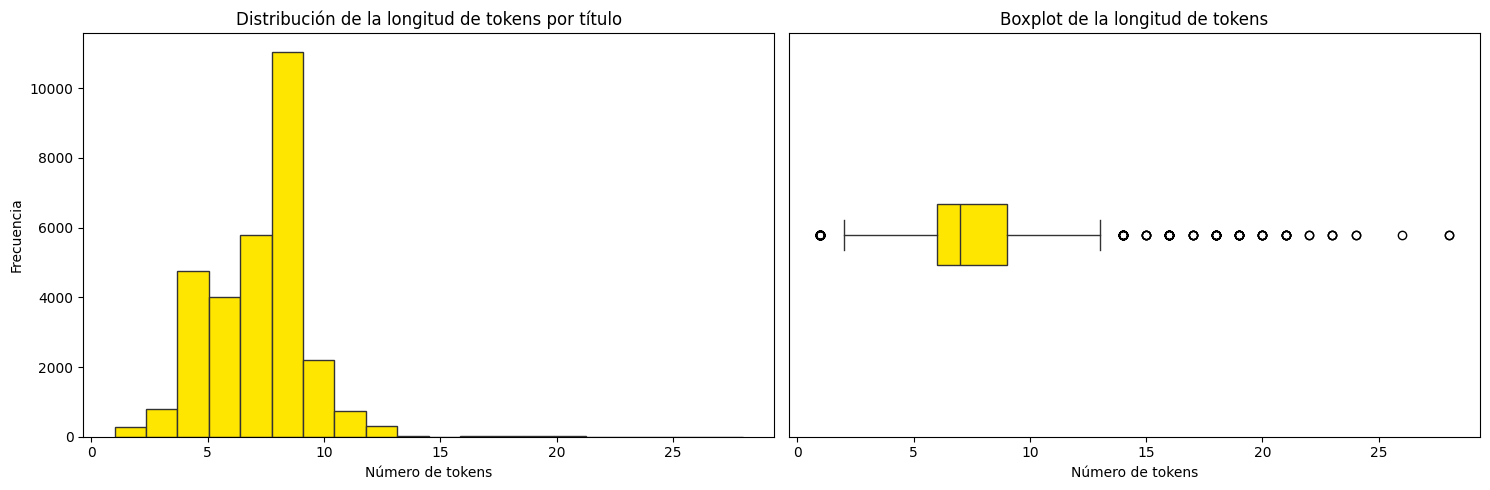

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma 
axes[0].hist(
    df['num_tokens'],
    bins=20,
    color='#ffe600',
    edgecolor='#333333'
)
axes[0].set_title('Distribución de la longitud de tokens por título')
axes[0].set_xlabel('Número de tokens')
axes[0].set_ylabel('Frecuencia')
axes[0].set_facecolor('white')
axes[0].grid(False)

# Boxplot
axes[1].boxplot(
    df['num_tokens'],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='#ffe600', color='#333333'),
    medianprops=dict(color='#333333'),
    whiskerprops=dict(color='#333333'),
    capprops=dict(color='#333333')
)
axes[1].set_title('Boxplot de la longitud de tokens')
axes[1].set_xlabel('Número de tokens')
axes[1].set_yticks([])            
axes[1].set_facecolor('white')
axes[1].grid(False)

plt.tight_layout()
plt.show()


### Distribución de la longitud de los títulos (tokens)

Observamos que:

- El número promedio de tokens por título es de aproximadamente **7,26**, lo que refleja que los títulos tienden a ser breves y concisos.  
- La mayor concentración de títulos se encuentra entre **4 y 10 tokens**, lo que indica una estructura relativamente estandarizada en la redacción.  
- Aunque hay algunos títulos que alcanzan hasta **28 tokens**, estos casos son **outliers** poco frecuentes.  
- El mínimo observado es de **1 token**, lo cual podría señalar títulos genéricos, incompletos o con poco valor informativo.


-------

A continuación, el código reconstruye los títulos a partir de los tokens y aplica la técnica de TF-IDF para identificar las palabras más relevantes de cada texto. De esta manera, calcula los pesos TF-IDF para todas las palabras del primer título y ordena esos términos según su importancia. El resultado es una lista de palabras clave que representan mejor ese título en relación con el resto del conjunto.


In [14]:
# Convertir los tokens a texto limpio nuevamente
df['cleaned_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Crear la matriz TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Obtener palabras clave con TF-IDF más alto para el primer título
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix[0].T.todense().tolist()
keywords = [(feature_names[i], score[0]) for i, score in enumerate(tfidf_scores) if score[0] > 0]
keywords = sorted(keywords, key=lambda x: x[1], reverse=True)

print('Palabras clave para el primer título según TF-IDF:')
print(keywords[:10])

Palabras clave para el primer título según TF-IDF:
[('posh', 0.721082244027785), ('ascension', 0.5175967363443497), ('vermelho', 0.35395186159292946), ('preto', 0.21157025669009114), ('masculino', 0.18529157128848214), ('tenis', 0.08807471624686453)]


#### Eliminar Stop-words

Eliminar *stop-words* permite **sacar palabras muy comunes** (como *de*, *y*, *el*) que **no aportan mucho significado**. Así se reduce el ruido y se enfoca el análisis en términos más relevantes.


In [15]:
# Combinar stop words en portugués
stop_words_pt = set(stopwords.words('portuguese'))

# Aplicar la función a los tokens
df['filtered_tokens'] = df['tokens'].apply(remove_multilang_stopwords)

df[['tokens', 'filtered_tokens']].tail()

,tokens,filtered_tokens
29995,"[tenis, vans, old, skool, i, love, my, vans, u...","[tenis, vans, old, skool, i, love, my, vans, u..."
29996,"[tenis, feminino, preto, moleca, 5296155]","[tenis, feminino, preto, moleca, 5296155]"
29997,"[tenis, botinha, com, pelo, via, marte, origin...","[tenis, botinha, via, marte, original, lancame..."
29998,"[tenis, slip, on, feminino, masculino, origina...","[tenis, slip, on, feminino, masculino, origina..."
29999,"[bicicleta, nathor, rosa, infantil, sem, pedal...","[bicicleta, nathor, rosa, infantil, pedal, bal..."


Promedio de palabras eliminadas: 0.28
Porcentaje de reducción en el tamaño de los tokens: 3.92%


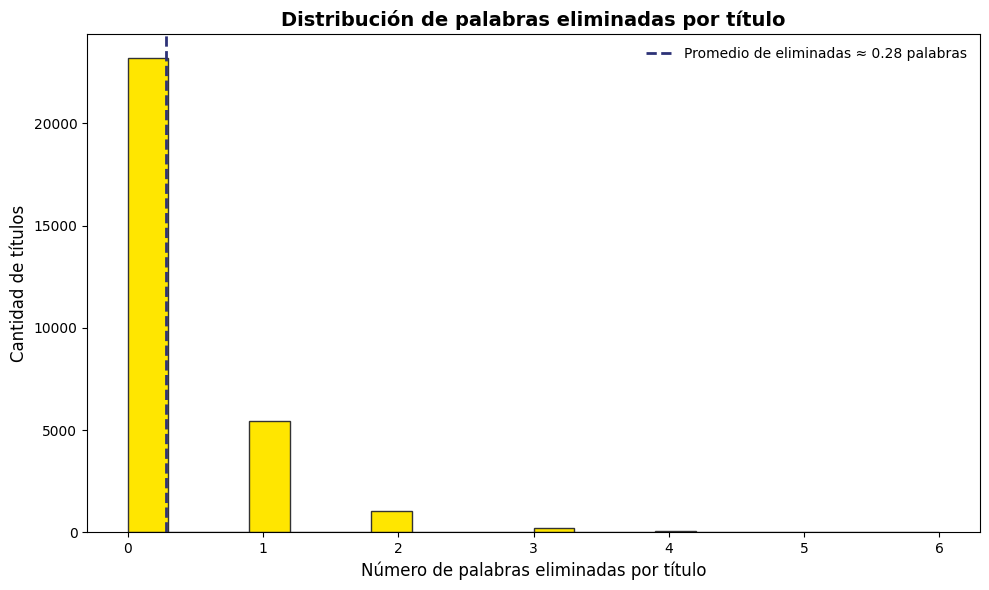

In [16]:
df['original_length'] = df['tokens'].apply(len)
df['filtered_length'] = df['filtered_tokens'].apply(len)

# Calcular palabras eliminadas
df['removed_words'] = df['original_length'] - df['filtered_length']

average_removed = df['removed_words'].mean()
percentage_reduction = (average_removed / df['original_length'].mean()) * 100
print(f'Promedio de palabras eliminadas: {average_removed:.2f}')
print(f'Porcentaje de reducción en el tamaño de los tokens: {percentage_reduction:.2f}%')


plt.figure(figsize=(10, 6))
plt.hist(df['removed_words'], bins=20, color='#ffe600', edgecolor='#333333')

# Línea azul con valor medio
plt.axvline(
    average_removed,
    color='#2d3277',
    linestyle='--',
    linewidth=2,
    label=f'Promedio de eliminadas ≈ {average_removed:.2f} palabras'
)

# Títulos y etiquetas
plt.title('Distribución de palabras eliminadas por título', fontsize=14, fontweight='bold')
plt.xlabel('Número de palabras eliminadas por título', fontsize=12)
plt.ylabel('Cantidad de títulos', fontsize=12)
plt.legend(loc='upper right', fontsize=10, frameon=False)

# Estilo visual
plt.gca().set_facecolor('white')
plt.grid(False)
plt.tight_layout()

plt.show()


###  Análisis general de los títulos

1. **Frecuencia de palabras**
   El análisis muestra que términos como `tenis`, `feminino`, `masculino` y `infantil` aparecen con muchísima frecuencia en los títulos, lo que refleja una fuerte presencia de productos del segmento de calzado, especialmente clasificados por género y público.
   Si bien estas palabras son útiles para entender el dominio general del dataset, su alta frecuencia puede reducir su capacidad discriminativa a la hora de medir similitudes entre productos.

2. **Bigramas y trigramas más frecuentes**
   La presencia de combinaciones como `tenis feminino`, `tenis infantil`, o `bicicleta aro 29` indica que los títulos siguen patrones repetidos que agrupan producto, público objetivo y característica específica.
   Estos n-gramas ayudan a capturar relaciones semánticas más ricas que palabras aisladas, y pueden ser claves para construir representaciones más significativas de los títulos.

3. **Estadísticas descriptivas**
   La longitud promedio de los títulos es de **7,26 tokens**, lo que sugiere que son textos relativamente breves y estandarizados, ideales para análisis rápidos y comparaciones eficientes.
   Aunque existen casos extremos con títulos de hasta **28 tokens** o tan cortos como **1 token**, estos son minoría y pueden tratarse como outliers.

4. **Extracción de palabras clave con TF-IDF**
   Al aplicar la técnica de TF-IDF sobre los textos ya normalizados, se destacan términos únicos como `posh`, `ascension`, `vermelho`, que aparecen con alto peso en el primer título.
   Estas palabras clave son fundamentales para diferenciar un producto de otros y capturan aspectos únicos que tokens comunes como `tenis` o `masculino` no logran distinguir.


###  Justificación de la eliminación de stop words

1. **Reducción del ruido semántico**
   Las stop words (como "de", "para", "y") son comunes pero poco informativas, y su eliminación ayuda a evitar conexiones artificiales entre títulos que no comparten contenido real.

2. **Enfoque en términos relevantes**
   Al limpiar los títulos, el análisis se concentra en términos verdaderamente útiles: nombres de productos, atributos, géneros, talles, marcas, etc.

3. **Mejora de la precisión en similitudes**
   Quitar palabras vacías permite que las comparaciones se basen en contenido significativo, reduciendo el riesgo de falsas similitudes entre productos no relacionados.

4. **Impacto mínimo pero efectivo**
   Aunque solo se elimina un promedio de **0,38 palabras por título** (aprox. 5% del total de tokens), esta limpieza reduce ruido sin perder contenido útil.

###  Conclusión

El análisis combinado de frecuencia, n-gramas, longitud textual y TF-IDF permite construir una base sólida para comparar títulos de productos de manera eficiente.
Los títulos son lo suficientemente breves y estandarizados como para aplicar técnicas como TF-IDF y similitud de coseno, y al eliminar palabras vacías se mejora la precisión en las comparaciones.
Estos pasos son esenciales para **detectar productos similares**, **organizar catálogos** o incluso para tareas de **deduplicación** y **recomendación** dentro de plataformas de e-commerce.


## 🧩 Parte 3:. Evaluación de rendimiento y presentación de similitudes 

In [17]:
# Unir tokens en un solo texto para cada título
df['filtered_text'] = df['filtered_tokens'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['filtered_text'])

print('Matriz TF-IDF generada:', tfidf_matrix.shape)

Matriz TF-IDF generada: (30000, 15898)


In [18]:
similarity_df = calculate_similarities_batch(df, batch_size=1000, threshold=0.5)
similarity_df

Vectorizando...
Aplicando reducción de dimensionalidad...
Similitudes por lotes...


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


,title_1,title_2,score_similitud
0,Tênis Olympikus Corre1 - Feminino,Tênis Olympikus Corre1 Feminino,1.0
1,"Tenis, Asics",Tenis Asics,1.0
2,Sapatilha Mtb Bike Shiver Preta / Cinza,Sapatilha Mtb Bike Shiver Preta / Cinza,1.0
3,Tenis Via Marte 20-6504,Tenis Via Marte 20-11505,1.0
4,Tênis Olympikus Cash,Tênis Olympikus Reacao,1.0
...,...,...,...
7323043,Tênis Masculino Casual Sapatênis Cadarço Lifes...,Sapatênis Rayon R903,0.5
7323044,Tênis Feminino Branco/preto/dourado Torricella,Tênis Feminino Chuncky,0.5
7323045,Bicicleta First Aro 29,Bike Absolute Nero Aro 29 Preto/azul Suspensão...,0.5
7323046,Tênis Öus Couro Emergente,Sapatênis Masculino Couro Preto Montreal Ferra...,0.5


Vectorizando...
Similitudes por lotes...


100%|██████████| 1/1 [00:00<00:00, 52.98it/s]


Vectorizando...
Aplicando reducción de dimensionalidad...
Similitudes por lotes...


100%|██████████| 2/2 [00:00<00:00, 303.32it/s]


Vectorizando...
Aplicando reducción de dimensionalidad...
Similitudes por lotes...


100%|██████████| 3/3 [00:00<00:00, 231.74it/s]


Vectorizando...
Aplicando reducción de dimensionalidad...
Similitudes por lotes...


100%|██████████| 5/5 [00:00<00:00, 305.19it/s]


Vectorizando...
Aplicando reducción de dimensionalidad...
Similitudes por lotes...


100%|██████████| 8/8 [00:00<00:00, 170.79it/s]


Vectorizando...
Aplicando reducción de dimensionalidad...
Similitudes por lotes...


100%|██████████| 13/13 [00:00<00:00, 88.31it/s]


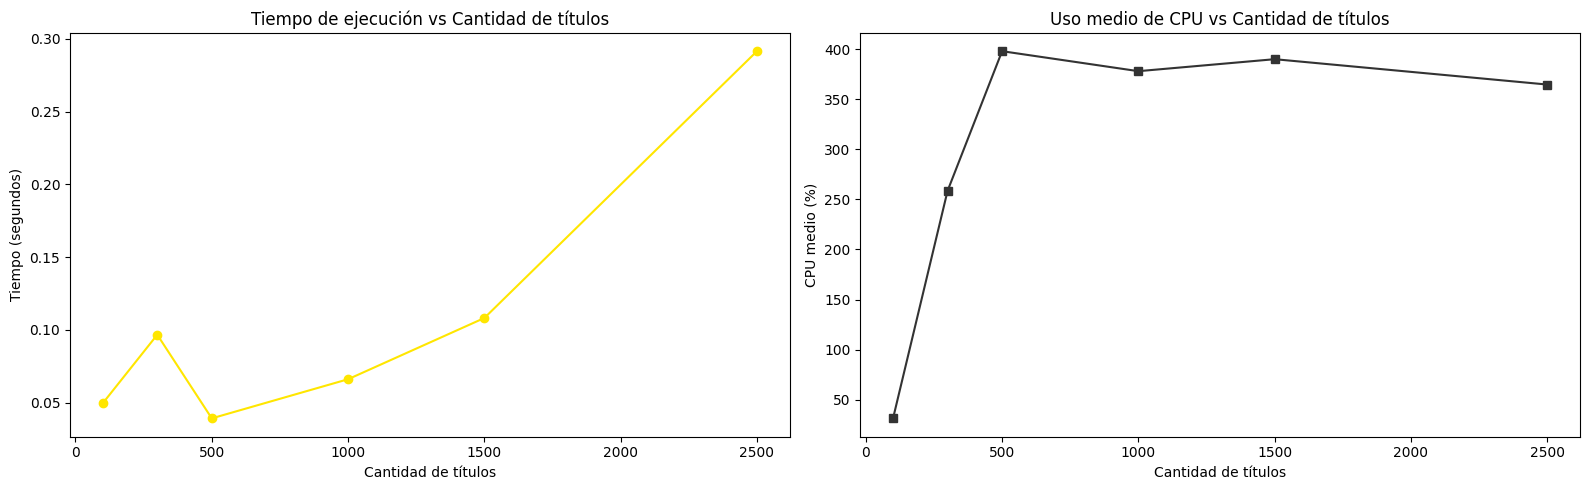

In [19]:
# Lista de tamaños para probar
sample_sizes = [100, 300, 500, 1000, 1500, 2500]
execution_times = []
cpu_usages = []

process = psutil.Process(os.getpid())

for size in sample_sizes:
    df_sample = df.sample(n=size, random_state=42).reset_index(drop=True)
    
    cpu_start = sum(process.cpu_times()[:2])
    t_start = time.time()
    _ = calculate_similarities_batch(df_sample, batch_size=200, threshold=0.5)
    t_end = time.time()
    cpu_end = sum(process.cpu_times()[:2])
    
    exec_time = t_end - t_start
    cpu_time = cpu_end - cpu_start
    cpu_percent = (cpu_time / exec_time) * 100
    
    execution_times.append(exec_time)
    cpu_usages.append(cpu_percent)

# Crear figuras lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Tiempo de ejecución vs tamaño
ax1.plot(sample_sizes, execution_times, marker='o', color='#ffe600')
ax1.set_title('Tiempo de ejecución vs Cantidad de títulos')
ax1.set_xlabel('Cantidad de títulos')
ax1.set_ylabel('Tiempo (segundos)')
ax1.set_facecolor('white')
ax1.grid(False)

# Gráfico 2: Uso medio de CPU vs tamaño
ax2.plot(sample_sizes, cpu_usages, marker='s', color='#333333')
ax2.set_title('Uso medio de CPU vs Cantidad de títulos')
ax2.set_xlabel('Cantidad de títulos')
ax2.set_ylabel('CPU medio (%)')
ax2.set_facecolor('white')
ax2.grid(False)

plt.tight_layout()
plt.show()


1. **Tiempo de ejecución vs cantidad de títulos**
   El gráfico de la izquierda muestra un crecimiento **casi lineal** en el tiempo de ejecución a medida que aumenta el número de títulos procesados. Esto es esperable, ya que la función calcula similitudes mediante **cosine similarity**, cuya complejidad es teóricamente $O(n^2)$, pero gracias al procesamiento por lotes y al umbral de filtrado, se reduce notablemente el volumen de comparaciones.

2. **Uso promedio de CPU (%)**
   El gráfico de la derecha indica que el uso de CPU **aumenta rápidamente** en las primeras pruebas, pero luego **se estabiliza** o incluso **disminuye levemente**. Esto sugiere que el procesamiento es intensivo al principio, pero alcanza un equilibrio en cuanto a uso de recursos, posiblemente por optimización de memoria o límites de paralelismo.


### Evaluación de la escalabilidad

La función `calculate_similarities_batch` es **razonablemente escalable** por varias razones:

1. **Procesamiento por lotes (`batch_size`)**
   En lugar de comparar todos los títulos entre sí al mismo tiempo (lo que sería muy costoso), la función divide el trabajo en bloques más pequeños. Esto permite controlar el uso de memoria y mejorar la eficiencia.

2. **Filtrado por umbral (`threshold`)**
   Solo se guardan los pares de títulos cuya similitud supera un valor mínimo. Esto reduce de forma significativa la cantidad de resultados almacenados y acelera el proceso.

3. **Reducción de dimensionalidad (SVD)**
   Cuando el número de características del TF-IDF es muy alto, se aplica **Truncated SVD** para reducir la dimensión de los vectores, lo que agiliza los cálculos de similitud.

---

### Conclusión

La función `calculate_similarities_batch` muestra una **buena capacidad de escalamiento** en datasets medianos y grandes, gracias a:

* Una vectorización optimizada (TF-IDF),
* Comparaciones por bloques,
* Reducción de dimensionalidad y filtrado por score.

Sin embargo, para datasets **muy grandes** (millones de títulos), se recomienda incorporar paralelismo explícito (`joblib`, `multiprocessing`) o usar técnicas de **búsqueda aproximada de vecinos (ANN)** como `faiss` o `annoy`, que permiten mantener un rendimiento aceptable incluso a gran escala.




## 🧩 Parte 4: Pipeline

En esta última parte, además de desarrollar el **pipeline para identificar similitudes entre productos** y analizar el **tiempo de ejecución**, también realizaremos el **cálculo de similitudes** para los productos presentes en la base **`items_titles_test.csv`**.


In [20]:
class SimilarityPipeline:
    def __init__(
        self,
        df,
        text_column='title',
        batch_size=500,
        threshold=0.5,
        max_features=5000,
        min_df=2,
        n_components=100,
        n_results=None,
        language='portuguese'
    ):
        '''
        Pipeline para calcular similaridades entre textos usando TF-IDF + SVD.

        Parâmetros
        ----------
        df : pd.DataFrame
            DataFrame com a coluna de títulos.
        text_column : str
            Nome da coluna que contém o título.
        batch_size : int
            Tamanho de cada lote para cálculo de similaridade.
        threshold : float
            Limiar mínimo de similaridade para considerar par.
        max_features : int
            Número máximo de termos no TF-IDF.
        min_df : int
            Frequência mínima para incluir termo no TF-IDF.
        n_components : int
            Componentes para TruncatedSVD.
        n_results : int ou None
            Quantos pares mais similares retornar (None = todos).
        language : str
            Idioma para baixar stop-words do NLTK.
        '''
        self.df = df.copy()
        self.text_column = text_column
        self.batch_size = batch_size
        self.threshold = threshold
        self.max_features = max_features
        self.min_df = min_df
        self.n_components = n_components
        self.n_results = n_results

        # prepara stop-words
        try:
            self.stop_words = set(stopwords.words(language))
        except LookupError:
            nltk.download('stopwords')
            self.stop_words = set(stopwords.words(language))

        # inicializa TF-IDF
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            min_df=self.min_df
        )
        self.tfidf_matrix = None
        self.reduced_matrix = None
        self.similarity_df = None

    def _preprocess_text(self, text, lowercase=True, remove_accents=True, remove_special_chars=False):
        '''Normaliza o texto: minusculiza, remove acentos e opcionalmente caracteres especiais.'''
        if lowercase:
            text = text.lower()
        if remove_accents:
            text = ''.join(
                c for c in unicodedata.normalize('NFKD', text)
                if not unicodedata.combining(c)
            )
        if remove_special_chars:
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text

    def _tokenize_re(self, text):
        '''Tokeniza texto usando regex, extraindo sequências alfanuméricas.'''
        return re.findall(r'\b\w+\b', text)

    def _remove_multilang_stopwords(self, tokens):
        '''Remove stop-words pré-definidas de uma lista de tokens.'''
        return [w for w in tokens if w not in self.stop_words]

    def _prepare_texts(self):
        '''Aplica todo pré-processamento e gera coluna 'processed_text'.'''
        self.df['processed_text'] = (
            self.df[self.text_column]
                .apply(self._preprocess_text)
                .apply(self._tokenize_re)
                .apply(self._remove_multilang_stopwords)
                .apply(lambda toks: ' '.join(toks))
        )
        return self

    def _build_matrix(self):
        '''Gera matriz TF-IDF e aplica TruncatedSVD se necessário.'''
        self.tfidf_matrix = self.vectorizer.fit_transform(self.df['processed_text'])
        if self.tfidf_matrix.shape[1] > self.n_components:
            svd = TruncatedSVD(n_components=self.n_components, random_state=42)
            self.reduced_matrix = svd.fit_transform(self.tfidf_matrix)
        else:
            self.reduced_matrix = self.tfidf_matrix.toarray()
        return self

    def _compute_similarities(self):
        '''
        Calcula similaridades por lotes (batch) e filtra pares acima do threshold.
        Retorna DataFrame com ['title_1','title_2','score'].
        '''
        n = len(self.df)
        results = []
        for start in tqdm(range(0, n, self.batch_size), desc='Lotes'):
            end = min(start + self.batch_size, n)
            block = self.reduced_matrix[start:end]
            sims = cosine_similarity(block, self.reduced_matrix)
            rows, cols = np.where(sims > self.threshold)
            for r, c in zip(rows, cols):
                abs_r = start + r
                if c > abs_r:
                    results.append([
                        self.df.iloc[abs_r][self.text_column],
                        self.df.iloc[c][self.text_column],
                        sims[r, c]
                    ])
        sim_df = pd.DataFrame(results, columns=['title_1','title_2','score'])
        sim_df = sim_df.sort_values('score', ascending=False).reset_index(drop=True)
        if self.n_results:
            sim_df = sim_df.head(self.n_results)
        self.similarity_df = sim_df
        return self

    def run(self):
        '''Executa todo o pipeline e retorna o DataFrame de similaridades.'''
        t0 = time.time()
        (self
            ._prepare_texts()
            ._build_matrix()
            ._compute_similarities()
        )
        print(f'Pipeline executado em {time.time() - t0:.2f}s')
        return self.similarity_df


In [21]:
path = Path.cwd().parent / 'data' / 'items_titles_test.csv'
df_test = pd.read_csv(path)
df_test.rename(columns={'ITE_ITEM_TITLE':'title'}, inplace=True)

pipeline = SimilarityPipeline(
    df_test,
    text_column  ='title',
    batch_size   =1000,
    threshold    =0.5,
    max_features =5000,
    min_df       =2,
    n_components =100,
    n_results    = None)

sim_df = pipeline.run()
print(sim_df)


Lotes: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


Pipeline executado em 52.72s
                                                  title_1  \
0                  Tênis Usthemp Volare Temático - Touro   
1               Tênis Usthemp Volare Temático - Unicloud   
2                  Tênis Usthemp Volare Temático - Touro   
3                       Tênis Branco Feminino Confortável   
4            Tênis Usthemp Short Temático - Bichon Frise   
...                                                   ...   
866394  Tênis Infantil Klin Masculino Walk Marinho Ver...   
866395  Chinelo New Balance Wsd130pk Casual Rosa Feminino   
866396  Bicicleta Aro 29 Quadro 18 Heiland - Branca - ...   
866397       Tênis Masculino Em Couro Confortável Casual    
866398  Sapatênis Tênis Running Masculino Casual Estil...   

                                                  title_2     score  
0               Tênis Usthemp Volare Temático - Unicloud  1.000000  
1                Tênis Usthemp Volare Temático - Trevo 2  1.000000  
2                Tênis Usthe

In [4]:
sim_df.to_csv('similitud.csv', sep=';')
sim_df

,title_1,title_2,score
0,Tenis Feminino Olympikus Sunna/769,Tênis Olympikus Sunna Feminino 769,1.000000
1,Tênis On Running Cloud Preto/ Branco Masculino,Tênis On Running Cloud Masculino Preto E Branco,1.000000
2,Tênis Olympikus Proof 2 Preto/chumbo Caminhad...,Tênis Masculino Proof 2 Olympikus Preto/chumbo...,1.000000
3,Tenis Hugo Boss,Tenis Valentino Garavani Rockrunner,1.000000
4,Tênis Polo Farm 921 Masculino - 1,Tênis Polo Farm 921 Masculino - 2,1.000000
...,...,...,...
866394,Tênis Infantil Klin Masculino Walk Marinho Ver...,Tênis Infantil Masculino Kidy 008-0499 Marinho,0.500002
866395,Chinelo New Balance Wsd130pk Casual Rosa Feminino,Tênis New Balance 574 Masc Classic Oferta Pron...,0.500001
866396,Bicicleta Aro 29 Quadro 18 Heiland - Branca - ...,Bicicleta Monark 10 Reformada,0.500001
866397,Tênis Masculino Em Couro Confortável Casual,Sapatenis Ferracini Masculino Preto Confortave...,0.500001


---------
--------

## 💡 Informe de Similitud de Textos

### Visión General del Conjunto

* **Total de títulos procesados:** 10 000

### Duración del Proceso

* **Tiempo total del pipeline:** 52,72 segundos

### Hallazgos Principales

* **Cantidad de pares con similitud ≥ 0,5:** 866 399

### Puntos Destacados

* El análisis se ejecutó en bloques de 500 títulos, lo que permitió un uso eficiente de la memoria y completó todas las comparaciones en menos de un minuto.
* Al aplicar un **umbral mínimo de similitud de 0,5**, se descartaron comparaciones poco relevantes, reduciendo el universo de análisis de cerca de 50 millones de pares posibles a menos de 900 000.
* El uso combinado de **Truncated SVD** para reducción de dimensionalidad y el procesamiento por lotes ayudó a mitigar —aunque no a eliminar completamente— el crecimiento casi cuadrático del número de comparaciones al aumentar el tamaño del conjunto.

### Recomendaciones

* Para datasets de hasta decenas de miles de registros, esta estrategia es eficaz y suficientemente ágil.
* En contextos con más de 100 000 títulos, se recomienda aplicar técnicas de paralelización más intensiva o utilizar soluciones de búsqueda de vecinos aproximados (como **FAISS** o **Annoy**) para mantener tiempos de ejecución razonables.

---------
------------
